# GPT3.5 Few-Shot Modeling for Software Citation Intent Prediction

In this notebok, we showcase an example of using a GPT3.5 model in a few-shot setting for predicting software citation intent.
Note that running this notebook requires access to an OpenAI API key, which can be retrieved from the OpenAI API website: https://openai.com/product#made-for-developers

In [1]:
import pandas as pd
import os
from openai import OpenAI
# your OpenAI key goes here
OPENAI_API_KEY = ""
client = OpenAI(api_key = OPENAI_API_KEY)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import warnings
import time
import plotly.express as px
from collections import Counter
warnings.simplefilter("ignore")

## Data Reading
The data used for training and testing has the following fields:
- **id**: paper_id (e.g. PMC id)
- **sentence**: sentence containing the software mention
- **used**: True if the intent of the software mentioned in the sentence is usage
- **created**: True if the intent of the software mentioned in the sentence is creation
- **mention**: True if the intent of the software mentioned in the sentence is mentioned
- **context**: context around the sentence, if available; this would be the leading and trailing sentence in the paragraph around the sentence
- **label**: categorical label; not that a sentence can only have one label
- **text**: same as sentence

In [2]:
data_df = pd.read_csv('../data/software_citation_intent_merged.csv')
LABEL2TEXT = {0 : 'creation', 1 : 'usage', 2 : 'mention', 3: 'none'}

In [3]:
data_df.head()

,Unnamed: 0,id,sentence,used,created,mention,context,label,text
0,0,PMC5189946,All of this analysis was implemented using Mat...,False,True,False,NaN,0,All of this analysis was implemented using Mat...
1,1,PMC4511233,"Code for calculating partition similarity, obt...",False,True,False,Since the probability of getting a given MI is...,0,"Code for calculating partition similarity, obt..."
2,2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,True,All behavioral statistical analyses were perfo...,2,All behavioral statistical analyses were perfo...
3,3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",True,False,False,NaN,1,"M-Track was written using Python 2.7, OpenCV 3..."
4,4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,True,False,"Mindboggle is a freely downloadable, open sour...",0,"Mindboggle is a freely downloadable, open sour..."


In [4]:
data_df['label'].unique()

array([0, 2, 1, 3])

In [5]:
data_df[data_df['label'] == 3].count()

Unnamed: 0    1000
id            1000
sentence      1000
used          1000
created       1000
mention       1000
context          8
label         1000
text          1000
dtype: int64

The data has been split into train and test, where test is used for validation. Note that in a zero-shot setting, we don't use the training split at all, and only test performance on the test split.

In [6]:
def update_context(df):
    df['context'] = df.apply(lambda x: x['context'] if x['context'] == x['context'] else x['sentence'], axis = 1)
update_context(data_df)

In [7]:
X_train_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_train.csv')
X_test_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_test.csv')
X_test_df['label_descriptive'] = X_test_df['label'].apply(lambda x: LABEL2TEXT[x])

update_context(X_train_df)
update_context(X_test_df)

In [8]:
Counter(X_test_df['label_descriptive'].to_list())

Counter({'usage': 449, 'none': 200, 'mention': 95, 'creation': 94})

## Few-shot GPT model

In [9]:
def predict_gpt(sentences, y_test, initial_message, model, print_every = 10, verbose = False):
    predicted_labels = []
    true_labels = []
    completed_sentences = []
    indices = range(len(sentences))
    for i, sentence, label in zip(indices, sentences, y_test):
        message = initial_message + [{"role": "user", "content": sentence.strip()}]
        try:
            completion = client.chat.completions.create(model=model, messages=message)
            predicted_class = completion.choices[0].message.content.lower().strip()
            if i % print_every == 0:
                if not verbose:
                    print('Predicting on sentence', str(i))
                else:
                    print(i, 'Sentence: ', sentence, '\nPredicted class:', predicted_class, 'Real class:' + label + '\n\n')
            predicted_labels.append(predicted_class)
            true_labels.append(label)
            completed_sentences.append(sentence)
        except:
            print('got an error')
            continue
    return predicted_labels, true_labels, completed_sentences

## Evaluation

In [10]:
def evaluate(true_labels, predicted_labels):
    p, r, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    accuracy = round(accuracy_score(true_labels, predicted_labels), 3)
    print('Precision: ', round(p, 3), 'Recall: ', round(r, 3), 'F1:', round(f1, 3), 'Accuracy:', accuracy)
    print(classification_report(true_labels, predicted_labels))

Notice that we are using n = 5 examples for the few-shot setting. This means that the model is seeing a number of 5 examples per class before making predictions. This parameter can be changed and experimented with

In [11]:
#number of few_shot examples 
num_examples_few_shot = 5

# this can be one of : 'sentence' or 'context'
pred_field = 'context' 

# sample num_examples_few_shot example sentences per label
examples_used = X_train_df[X_train_df['label_descriptive'] == 'usage'].sample(num_examples_few_shot)[pred_field].to_list()
examples_created = X_train_df[X_train_df['label_descriptive'] == 'creation'].sample(num_examples_few_shot)[pred_field].to_list()
examples_mentioned = X_train_df[X_train_df['label_descriptive'] == 'mention'].sample(num_examples_few_shot)[pred_field].to_list()
examples_none = X_train_df[X_train_df['label_descriptive'] == 'none'].sample(num_examples_few_shot)[pred_field].to_list()

# PROMPT 1
initial_message = [{"role": "system", 
                "content": "You are a scientist trying to figure out the citation intent behind software mentioned in sentences coming from research articles. Your four categories are: creation, usage, mention, or none. The definitions of the classes are: \
                - creation: software was created by the authors of the paper \
                - usage: software was used in the paper \
                - mention: software was mentioned in the paper, but not used, nor created \
                - none: none of the previous 3 categories apply \
                You need to output one category only."}]
for example in examples_used:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'usage'}]
for example in examples_created:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'creation'}]
for example in examples_mentioned:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'mention'}]
for example in examples_none:
    initial_message += [{"role": "user", "content" : example}]
    initial_message += [{"role": "assistant", "content" : 'none'}]

### Test split

In [12]:
test_sentences = X_test_df[pred_field].to_list()
y_test = X_test_df['label_descriptive'].to_list()
y_test_pred_completed, y_test_true_completed, test_completed_sentences = predict_gpt(test_sentences, y_test, initial_message, 'gpt-3.5-turbo', print_every = 1)

Predicting on sentence 0
Predicting on sentence 1
Predicting on sentence 2
Predicting on sentence 3
Predicting on sentence 4
Predicting on sentence 5
Predicting on sentence 6
Predicting on sentence 7
Predicting on sentence 8
Predicting on sentence 9
Predicting on sentence 10
Predicting on sentence 11
Predicting on sentence 12
Predicting on sentence 13
Predicting on sentence 14
Predicting on sentence 15
Predicting on sentence 16
Predicting on sentence 17
Predicting on sentence 18
Predicting on sentence 19
Predicting on sentence 20
Predicting on sentence 21
Predicting on sentence 22
Predicting on sentence 23
Predicting on sentence 24
Predicting on sentence 25
Predicting on sentence 26
Predicting on sentence 27
Predicting on sentence 28
Predicting on sentence 29
Predicting on sentence 30
Predicting on sentence 31
Predicting on sentence 32
Predicting on sentence 33
Predicting on sentence 34
Predicting on sentence 35
Predicting on sentence 36
Predicting on sentence 37
Predicting on sentence

In [13]:
print('Finished', len(y_test_true_completed), 'sentences out of', len(X_test_df))
evaluate(y_test_true_completed, y_test_pred_completed)

Finished 838 sentences out of 838
Precision:  0.546 Recall:  0.512 F1: 0.463 Accuracy: 0.5
              precision    recall  f1-score   support

    creation       0.72      0.57      0.64        94
     mention       0.21      0.15      0.17        95
        none       0.38      0.98      0.55       200
       usage       0.88      0.35      0.50       449

    accuracy                           0.50       838
   macro avg       0.55      0.51      0.46       838
weighted avg       0.67      0.50      0.49       838



In [14]:
Counter(y_test_true_completed)

Counter({'usage': 449, 'none': 200, 'mention': 95, 'creation': 94})

### CZI validation dataset

In [21]:
czi_val_df = pd.read_csv('../data/czi_val_merged.csv').drop_duplicates()
czi_val_df['label'] = czi_val_df['label'].apply(lambda x: 'mention' if x == 'none' else x)
test_sentences_czi = czi_val_df['text'].to_list()
y_czi_val = czi_val_df['label'].to_list()
y_pred_completed_czi, y_true_completed_czi, test_completed_sentences_czi = predict_gpt(test_sentences_czi, y_czi_val, initial_message, "gpt-3.5-turbo", print_every = 1)

Predicting on sentence 0
Predicting on sentence 1
Predicting on sentence 2
Predicting on sentence 3
Predicting on sentence 4
Predicting on sentence 5
Predicting on sentence 6
Predicting on sentence 7
Predicting on sentence 8
Predicting on sentence 9
Predicting on sentence 10
Predicting on sentence 11
Predicting on sentence 12
Predicting on sentence 13
Predicting on sentence 14
Predicting on sentence 15
Predicting on sentence 16
Predicting on sentence 17
Predicting on sentence 18
Predicting on sentence 19
Predicting on sentence 20
Predicting on sentence 21
Predicting on sentence 22
Predicting on sentence 23
Predicting on sentence 24
Predicting on sentence 25
Predicting on sentence 26
Predicting on sentence 27
Predicting on sentence 28
Predicting on sentence 29
Predicting on sentence 30
Predicting on sentence 31
Predicting on sentence 32
Predicting on sentence 33
Predicting on sentence 34
Predicting on sentence 35
Predicting on sentence 36
Predicting on sentence 37
Predicting on sentence

In [22]:
print('Completed', len(test_completed_sentences_czi), '/', len(test_sentences_czi))
evaluate(y_true_completed_czi, y_pred_completed_czi)

Completed 210 / 210
Precision:  0.454 Recall:  0.195 F1: 0.269 Accuracy: 0.338
              precision    recall  f1-score   support

    creation       0.50      0.20      0.29        10
     mention       0.33      0.22      0.26        23
        none       0.00      0.00      0.00         0
       usage       0.98      0.36      0.53       177

    accuracy                           0.34       210
   macro avg       0.45      0.19      0.27       210
weighted avg       0.89      0.34      0.49       210



### Error Analysis

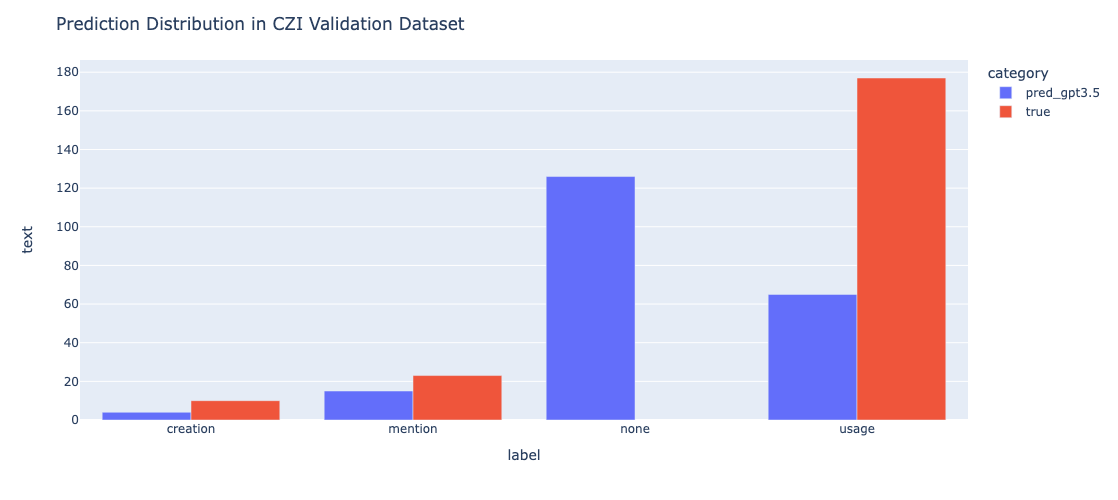

In [23]:
def get_pred_label(x, completed_sentences, y_pred_completed):
    for sent, label in zip(completed_sentences, y_pred_completed):
        if sent == x:
            return label
    return 'no_prediction'
    
czi_val_df['category'] = 'true'
czi_val_df['pred_label'] = czi_val_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences_czi, y_pred_completed_czi))
czi_val_df_pred = czi_val_df.copy()
czi_val_df_pred['category'] = 'pred_gpt3.5'
czi_val_df_pred['label'] = czi_val_df_pred['pred_label']


czi_val_df_all = pd.concat([czi_val_df_pred, czi_val_df])

labels_grouped = czi_val_df_all.groupby(['label', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in CZI Validation Dataset')

#### False positives

In [24]:
pd.set_option('display.max_colwidth', 1000)
czi_val_df[(czi_val_df['pred_label'] == 'mention') & (czi_val_df['label'] != 'mention')]

,doi_link,source,text,software,intent,label,category,pred_label
13,https://doi.org/10.3390/genes9080378,2.4. Simple Sequence Repeat Loci Identification and Primer Design,"The transcriptomes were analyzed using the MIcroSAtellite identification tool (MISA) (http://pgrc.ipk-gatersleben.de/misa/misa.html) for identifying SSRs with a minimum of ten repeats for di-nucleotide motifs, five repeats for tri- and tetra-, four repeats for penta- and hexa-nucleotide motifs",MIcroSAtellite,used,usage,true,mention
74,https://doi.org/10.1128/MRA.01400-20,ANNOUNCEMENT,The quality of assembly was assessed with QUAST 5.0.2 (15),QUAST,used,usage,true,mention
111,https://doi.org/10.1371/journal.pone.0054359,fig_caption,The middle shows the same set of SNPs extended by those that are in tight genetic linkage (r2 = 0.8) according to HaploReg [30],HaploReg,used,usage,true,mention
124,https://doi.org/10.3390/membranes11030175,1. Introduction,"The composition of the model solution after sodium carbonate pre-treatment used as the feed for the stage of membrane distillation with crystallization was calculated with the PHREEQC program, and the performance of the last two stages was modeled using Simulink program",Simulink,used,usage,true,mention
127,https://doi.org/10.1371/journal.pone.0107148,Multi-Level Modeling,"The key simplification in this paper, assuming that all lipoplexes have the same size, along with listing all possible endosome sizes, makes it possible to formulate the model in SBML and use Copasi to run the simulations",Copasi,used,usage,true,mention
135,https://doi.org/10.3390/jcm10071339,Statistical Analysis,"Statistical analyses were carried out using the PQStat statistical package, version 1.6.4.110 (PQStat Software, Poznan, Poland)",PQStat,used,usage,true,mention
401,https://joss.theoj.org/papers/10.21105/joss.05420,title,libscientific: A Powerful C Library for Multivariate Analysis,libscientific,creation,creation,true,mention
403,https://joss.theoj.org/papers/10.21105/joss.05777,title,gesel: a JavaScript package for client-side gene set enrichment,gesel,creation,creation,true,mention
404,https://joss.theoj.org/papers/10.21105/joss.05853,title,Qiskit Dynamics: A Python package for simulating the time dynamics of quantum systems,Qiskit Dynamics,creation,creation,true,mention
409,https://joss.theoj.org/papers/10.21105/joss.05580,title,SMART: Spatial Modeling Algorithms for Reactions and Transport,SMART,creation,creation,true,mention


#### False negatives

In [25]:
czi_val_df[(czi_val_df['label'] == 'usage') & (czi_val_df['pred_label'] != 'usage')]

,doi_link,source,text,software,intent,label,category,pred_label
0,https://doi.org/10.1371/journal.pone.0043845,10. Confocal microscopy,"Confocal laser scanning was performed on a Olympus Fluoview 500 system using the 40×objective, and Fluoview software was used for image analysis.",Fluoview,used,usage,true,none
1,https://doi.org/10.1155/2014/395212,5. Simulation Results and Analysis,"In Figure 11, p miss of SVM-SMP is nearly equal to 0, which is much better than SVM-LA",SVM,used,usage,true,none
3,https://doi.org/10.1186/s13046-018-0997-7,paper_abstract,"Finally, we investigated the potential molecular mechanism of ARNTL by gene set enrichment analysis (GSEA), dual Luciferase reporter assay and chromatin immunoprecipitation assay",analysis (GSEA),used,usage,true,none
4,https://doi.org/10.7717/peerj.9470,Conclusions,"The GitHub repository for this study has been created, including the Python scripts and the datasets used in this study (see https://github.com/smiile8888/rna-splice-sites-recognition)",Python,used,usage,true,creation
5,https://doi.org/10.1186/1471-2458-9-225,Statistical methods,"SPSS for Windows, release 13 [13] was used for the statistical analyses.",SPSS,used,usage,true,none
...,...,...,...,...,...,...,...,...
190,https://doi.org/10.1038/s41598-017-12066-3,Data analysis,"Statistical analyses were performed with SPSS16.0 (SPSS Inc., Chicago, Illinois, USA), and graphs were created using GraphPad Prism, version 5.0 (GraphPad Software Inc., San Diego, California, USA).",GraphPad,used,usage,true,none
191,https://doi.org/,NaN,"Again, we note a striking lack of agreement between calls resulting from CNAM and GADA.",GADA,used,usage,true,none
192,https://doi.org/10.7759/cureus.9227,paper_abstract,"The statistical analysis of data was performed with the Statistical Package for the Social Sciences (SPSS) for Windows, Version 13.0 (SPSS Inc, Chicago, IL)",Statistical Package for the Social Sciences (SPSS),used,usage,true,none
195,https://doi.org/10.1371/journal.pone.0160520,Discussion,"We found inflammatory processes and TNF signaling were significantly associated with sALS group-specific gene expression changes (IPA) using independent exploratory DEG tests (Cuffdiff2, DESeq2, and EdgeR) and an unsupervised gene network analysis (WGCNA)",Cuffdiff2,used,usage,true,none


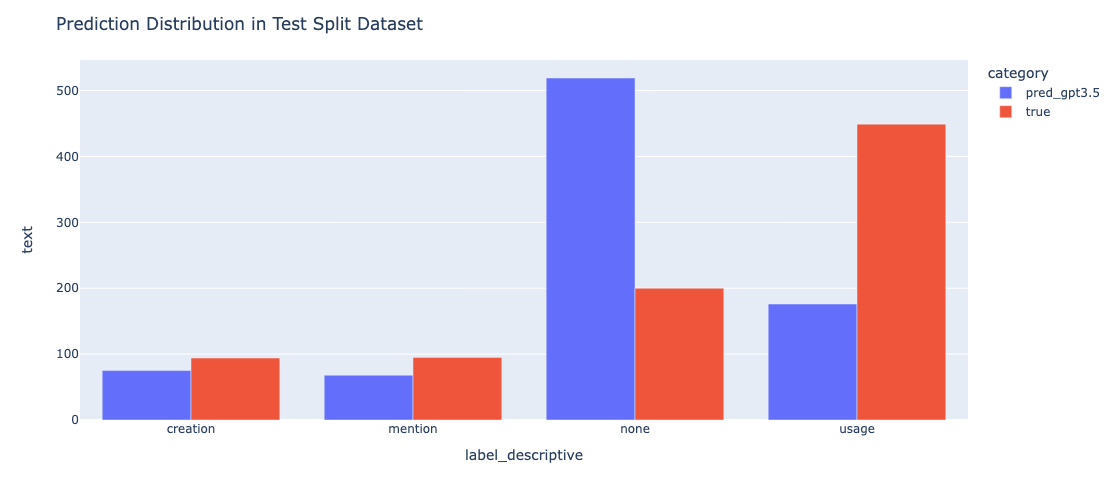

In [27]:
X_test_df['category'] = 'true'
X_test_df['pred_label'] = X_test_df['context'].apply(lambda x: get_pred_label(x, test_completed_sentences, y_test_pred_completed))
X_test_df_pred = X_test_df.copy()
X_test_df_pred['category'] = 'pred_gpt3.5'
X_test_df_pred['label_descriptive'] = X_test_df_pred['pred_label']

X_test_df_all = pd.concat([X_test_df_pred, X_test_df])

labels_grouped = X_test_df_all.groupby(['label_descriptive', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label_descriptive', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in Test Split Dataset')